***
# REPRODUCING LUCA'S RESULTS
***

***
# Introduction 
***

This notebook serves as a comprehensive guide to understanding and configuring all the necessary components required to replicate Luca's results.

## Important remarks 

### Domain of simulation and associated frame
<div style="float:center; margin-left:100px;">
    <img src="Images/Literature/domain.png" alt="Figure 1 du papier" width="800">
</div>

  - $(x, y, z)$ represent streamwise, wall-normal, and spanwise directions respectively.
  - $(u, v, w)$ represent corresponding velocity components.

***
# Gmsh
***

# Mesh Implementation Parameters

## All Parameters

We replicate the **minimal channel** simulation described in "Guastoni, L., Rabault, J., Schlatter, P., Azizpour, H., & Vinuesa, R. (2023). Deep reinforcement learning for turbulent drag reduction in channel flows. The European Physical Journal. E, Soft Matter, 46". It is an open-channel flow with the following parameters : 

| Parameter | Explanation                     | Choice Made |
|-----------|---------------------------------|-------------|
| Re        | Reynolds number                 | 180         |
| Ly        | Height of the domain             | $h$         |
| Lx        | Length of the domain             | $2.67h$     |
| Lz        | Width of the domain              | $0.8h$      |
| Ny        | Resolution in the y-direction   | 65          |
| Nx        | Resolution in the x-direction   | 16          |
| Nz        | Resolution in the z-direction   | 16          |

## Meshing the Domain

### Chebysev nodes 

> Trefethen, L. N. (2019). Approximation theory and approximation practice, extended edition. Society for Industrial and Applied Mathematics.
> 
> Latex :
> > @book{trefethen2019approximation,
  title={Approximation theory and approximation practice, extended edition},
  author={Trefethen, Lloyd N},
  year={2019},
  publisher={SIAM}
}

Chebyshev nodes, also known as Chebyshev points or Chebyshev zeros, are specific points on the interval $[-1, 1]$ that are used in approximation theory, numerical analysis, and other areas of mathematics. They are defined as the roots of the Chebyshev polynomials of the first kind, which are orthogonal polynomials defined on the interval $[-1, 1]$.

The $n$ Chebyshev nodes, denoted as $x_i$ for $i = 1, 2, ..., n$, are given by:

$$
x_i = \cos\left(\frac{(2i - 1)\pi}{2n}\right)
$$

These nodes are used in various numerical methods, such as Chebyshev interpolation, where they provide better approximation properties compared to equidistant nodes (like those obtained from equally spaced points). They are particularly useful for approximating functions with oscillatory behavior or for problems where minimizing interpolation error is important.

### Mesh choice

For the $y$-direction, we opt for Chebyshev nodes due to their ability to achieve higher resolution near the wall. However, considering our open channel configuration, we only utilize half of the Chebyshev nodes. This choice leads to the following distribution with $N_y$ the resolution in the $y$ direction:

$$
y_i = 1 - \cos\left(\frac{\pi (i+1)}{2 N_y}\right)
$$

The lines of code below provide a graphical representation of this example.




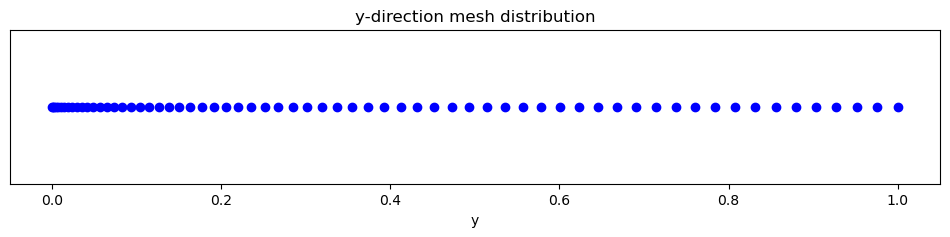

In [45]:
import numpy as np
import matplotlib.pyplot as plt

Ny = 65
Ly = 1 
y = np.zeros(Ny)

for i in range(Ny-1):
    y[i] = 1 - np.cos(np.pi * (i+1) / (2 * Ny))

y[Ny-1] = Ly

plt.figure(figsize=(12, 2))  # Adjusted width and decreased height
plt.plot(y, np.ones(Ny), marker='o', linestyle='', color='b')  # Plotting only points
plt.xlabel('y')
plt.title('y-direction mesh distribution')
plt.gca().set_aspect('auto')  # Setting aspect ratio to auto
plt.gca().axes.get_yaxis().set_visible(False)  # Hiding y-axis label
plt.show()



Regarding the $x$ and $z$ directions, we employ a regular distribution.

# Gmsh Implementation

***
**Remark: Practical considerations**

In practice, it's crucial to be cautious, especially as Ly is set to 1. This is a common practice in the literature, as it is practical with the Chebyshev definition. However, there's a tendency to inadvertently interchange 1 and Ly in calculations and code.

***

We begin with the reference:

> [Link to reference](https://how5.cenaero.be/content/ws2-les-plane-channel-ret550)

And we customize it according to our parameters (".geo" file):

In [4]:
// ---------------------------------------------------
// ----------- LUCA GMSH / REFERENCE GMSH ------------
// ---------------------------------------------------

// ----------- BEGIN INPUT ------------

N = 1; // INPUT N=p+1

Re = 180;

nl = Round(16./N); 
ny = Round(64/N);

//#z -> 16
//#x -> 32

// ----------- END INPUT --------------

lc = 2*Pi/nl;
Printf("dx+ = %g",lc*Re);

lx=2*Pi;
lz=Pi;
Point(1) = {0, 0, 0, lc};
line[] = Extrude {2*Pi, 0, 0.} {
  Point{1}; Layers{Round(2*nl)};
};

//Physical Line(1) = {line[1]};
surface[] = Extrude {0, 0, Pi} {
  Line{line[1]}; Layers{nl}; Recombine;
};

Printf("ny = %g",ny);

For i In {0:ny-2}
  h = 1 - Cos(Pi*(i+1)/(2*ny));
  //+= h0*r^i;
  y[i] = h;
  //y[ny-i-2] = 1-h;
EndFor
//y[ny/2-1] = 0.5;
y[ny-1] = 1.;

For i In {0:ny-1}
  Printf("y+[%g] = %g", i, Re*y[i]);
  layer[i] = 1;
EndFor
For i In {0:ny-1}
  layer[i] = 1;
EndFor

volume[] = Extrude {0.0,1.0,0.0} {
  Surface{surface[1]}; Layers{ layer[], y[] }; Recombine;
};

Physical Surface("wall") = {5};
Physical Surface("symmetry") = {27};

//+ Set the fluid region
Physical Volume("fluid") = {1};

//+ Set every surface to periodic, using surf(1) as master
Physical Surface("Periodic") = {14,18,22,26};

//+ Set the output mesh file version
Mesh.MshFileVersion = 2.2;

//+ Options controlling mesh generation
Mesh.ElementOrder = 3; //+ Order 3 mesh
Mesh 3;                //+ Volumetric mesh

//+ Generate the periodicity between surface pairs
Periodic Surface {18} = {26} Translate {lx, 0, 0};
//Periodic Surface {21} = {13} Translate {0,y*2*pi, 0};
Periodic Surface {22} = {14} Translate {0, 0, lz};

SyntaxError: invalid syntax (1668218311.py, line 1)

> Importnat to do : See Luca to clarify problem 

In [ ]:
// ----------------------------------------------------------------
// ----------- MY MODIFICATION TO MAKE MINIMAL CHANNEL ------------
// ----------------------------------------------------------------


// ----------- PARAMETERS  ------------

Re = 180; // Reynolds number

h = 1; // # Common practise as Chebysev polynom but be aware that sometimes it will be 2 or something else (like in SIMSOn)

Lx = 2.67*h; // Length of the domain
Ly = h; // Height of the domain 
Lz = 0.8*h; // Width of the domain 

Nx = 16; // Resolution in the x-direction
Ny = 64; // Resolution in the y-direction # WHY 65 in Luca's paper ? because SIMSON asks see with ALYA if it changes 
Nz = 16; // Resolution in the z-direction

// ----------- MESH --------------

// ----------- Creation of (x,z) regular meshed plan --------------

// Characteristic mesh size 
lc = Lx/Nx;
Printf("dx+ = %g", lc*Re); 

// Define a point at the origin with a characteristic size lc
Point(1) = {0, 0, 0, lc};

// Extrude the point to create a line in the x-direction
line[] = Extrude {Lx, 0, 0.} {
  Point{1}; Layers{Round(Nx)}; 
};

// Extrude the line to create a surface in the z-direction
surface[] = Extrude {0, 0, Lz} {
  Line{line[1]}; Layers{Nz}; Recombine;
};


// ----------- Creation of the semi-Chebysev nodes --------------


Printf("Ny = %g", Ny); 

// Generate vertical positions of mesh points in the y-direction
For i In {0:Ny-2} // # Here Ny-2 include not like Python
  y[i] = 1 - Cos(Pi*(i+1)/(2*Ny)); 
EndFor

// Set specific vertical positions
y[Ny-1] = 1.; // # We ensure that wa have Ly at the end and that the point o goto far or not enough because of approximation 

// Print y+ values for each vertical position
For i In {0:Ny-1}
  Printf("y+[%g] = %g", i, Re*y[i]);
  layer[i] = 1;
EndFor

// ----------- Creation of the all volume --------------

// Create a volumetric mesh based on the generated geometry
volume[] = Extrude {0.0, 1.0, 0.0} {
  Surface{surface[1]}; Layers{layer[], y[]}; Recombine;
};



// ----------- Assignation --------------

// Assign physical entities to surfaces and volumes # See directly on the applciation, it is Gmsh that sets the number associated 
Physical Surface("wall") = {5};
Physical Surface("symmetry") = {27};
Physical Volume("fluid") = {1};


// ----------- Setting of boundary conditions --------------

// Set every surface to be periodic, using surf(1) as master
Physical Surface("Periodic") = {14, 18, 22, 26};


// Generate periodicity between surface pairs
Periodic Surface {18} = {26} Translate {Lx, 0, 0};
Periodic Surface {22} = {14} Translate {0, 0, Lz};

// ----------- Gmsh particular options --------------

// Set the output mesh file version
Mesh.MshFileVersion = 2.2;

// Options controlling mesh generation
Mesh.ElementOrder = 3; // Order 3 mesh
Mesh 3;                // Volumetric mesh



### Mesh obtained 

Here are images of the side view $(x, y, 0)$, front view $(0, y, z)$, and top view $(x, 0, z)$:

<div style="display: flex; justify-content: space-between; margin: 20px auto;">
    <img src="Images/Literature/side_view.png" alt="Side View" width="400" style="object-fit: contain;">
    <img src="Images/Literature/front_view.png" alt="Front View" width="400" style="object-fit: contain;">
    <img src="Images/Literature/top_view.png" alt="Top View" width="400" style="object-fit: contain;">
</div>

***

# Governing equations 

***

# Equations

In all simulations, an incompressible flow is considered, governed by the Navier–Stokes equations in non-dimensional form:

$$
\begin{align*}
\nabla \cdot \mathbf{u} &= 0, \\
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} + \nabla P &= \frac{1}{Re} \nabla^2 \mathbf{u},
\end{align*}
$$

where :
$$ Re = \frac{v \cdot L}{\nu}, $$ 

with $\rho$ the density of the fluid, $v$ the characteristic velocity of the fluid, $L$ a characteristic length of the flow (e.g., the height $h$ of the open channel), and $\nu$ kinematic viscosity.

Under the assumption of an incompressible flow, these equations are decoupled from the energy equation. Thus, the pressure $P$ acts as a Lagrange multiplier to enforce the incompressibility constraint.

***

**Remark: Equations**

If ALYA cannot work with three components plus pressure, a method to create two sets of equations for two components can be implemented, as discussed on page 5.

***

***
**Remark: Reynolds number**

Two Reynolds numbers are used :
1. The Reynolds number derived from the Navier-Stokes equations.
2. The friction Reynolds number, defined by:
   - $Re_{\tau} = \frac{u_{\tau}h}{\nu}$
   - $u_{\tau} = \frac{\tau_{w}}{\rho}$
   - $\tau_{w}$ is the wall-shear stress, $\rho$ is fluid density, and $\nu$ is kinematic viscosity.

The simulation is performed using $Re_{\tau}$ rather than $Re$.
***

***
**Remark: Reynolds number and computational cost**

The computational expense of simulations escalates rapidly with increasing Reynolds numbers, especially when all pertinent flow characteristics must be resolved. Consequently, selecting the domain size entails striking a balance between accommodating the largest turbulent structures and managing computational expenses. A strategy to mitigate these costs was proposed by Jiménez and Moin (1991). They advocated for limiting the domain size to the minimal flow unit where self-sustained turbulent flow occurs. Within this computational box, only a single low-speed streak is simulated. This approach ensures adequate representation of small scales within the minimal flow unit, as smaller domains offer finer resolution with the same number of points (Jiménez & Moin, 1991).
***

# Boundary Conditions

Consideration is given to an open channel flow.

## Bottom Wall Boundaries

At the bottom wall, no-slip conditions are enforced:
$$
\begin{align*}
u(y=0) &= 0, \\
v(y=0) &= 0, \\
w(y=0) &= 0.
\end{align*}
$$

## Top Boundaries

Symmetry boundaries are imposed at the top:
$$
\begin{align*}
v(y=L_y) &= 0, \\
\frac{\partial u}{\partial y}(y=L_y) &= 0, \\
\frac{\partial v}{\partial y}(y=L_y) &= 0.
\end{align*}
$$

## Spanwise Direction

Periodic boundary conditions are applied in the spanwise direction:

$$
\begin{align*}
u(x=0) &= u(x=L_x), \\
v(x=0) &= v(x=L_x), \\
w(x=0) &= w(x=L_x),
\end{align*}
$$

and

$$
\begin{align*}
u(z=0) &= u(z=L_z), \\
v(z=0) &= v(z=L_z), \\
w(z=0) &= w(z=L_z).
\end{align*}
$$


***

**Remark: Periodic conditions**

Periodic conditions are implemented in Gmsh.

***

***

# Mean flow statistics

***

# Symmetries

Because of the symmetry of the open channel, the flow is statistically independent of $x$ and $z$.

# Mean

The mean streamwise velocity $\langle u \rangle$ is averaged in time and the homogeneous directions. The fluctuation intensity for each velocity component is defined as $u_{i,RMS} = \langle (u_i - \langle u_i \rangle)^2 \rangle = | u_{i}'| $. 

# Spatial correlation

We define the spatial correlation of two quantities as:

$$
R_{ij}(\mathbf{x}, \mathbf{r}, t) = \langle u_i(\mathbf{x} + \mathbf{r}, t)u_j(\mathbf{x}, t) \rangle, \qquad (4.1)
$$

where $\mathbf{r} = (\delta x, \delta y, \delta z)$ indicates the spatial distance for which the correlation is being computed. Note that the correlations do not depend on the position $\mathbf{x}$ in the homogeneous directions. The correlation of the different quantities sharply decreases when $\| \mathbf{r} \| $ increases, as shown in several research works (including Nakagawa & Nezu 1981, for open-channel flows). By leveraging the spatial correlation between two variables, it is possible to create a model that predicts one variable based on the knowledge of the spatial distribution of the other.


***
# How to validate our simulations ?
***

The standard channel flow is frequently selected as a benchmark in literature and has served as the reference case for fundamental turbulence research over the past few decades. Given the similarity between open-channel flow far from the top and standard channel flow, we can compare the two to assess the performance of the latter. This is precisely what Luca did, and the following are his findings:

<div style="text-align:center;">
    <img src="Images/Literature/channel_vs_open.png" alt="Figure 1 du papier" width="600" style="margin-left: auto; margin-right: auto;">
</div>

### Reference for open channel 

> Kim, J., Moin, P., & Moser, R. (1987). Turbulence statistics in fully developed channel flow at low Reynolds number. Journal of Fluid Mechanics, 177, 133–166. doi:10.1017/S0022112087000892
> > 
> Latex :
> > @article{Kim_Moin_Moser_1987, title={Turbulence statistics in fully developed channel flow at low Reynolds number}, volume={177}, DOI={10.1017/S0022112087000892}, journal={Journal of Fluid Mechanics}, author={Kim, John and Moin, Parviz and Moser, Robert}, year={1987}, pages={133–166}} <div></div>

### Reference for correspondance between open channel and standard channel
In standard channel flows, the effect of each wall can extend beyond the centerline of the channel (Lozano-Duran et al. 2012). For this, open channel flows are more suitable to analyze the effect of an individual wall on the fluid flow.

> Lozano-Durán, A., Flores, O., & Jiménez, J. (2012). The three-dimensional structure of momentum transfer in turbulent channels. Journal of Fluid Mechanics, 694, 100–130. doi:10.1017/jfm.2011.524
> > 
> Latex :
> > @article{Lozano-Durán_Flores_Jiménez_2012, title={The three-dimensional structure of momentum transfer in turbulent channels}, volume={694}, DOI={10.1017/jfm.2011.524}, journal={Journal of Fluid Mechanics}, author={Lozano-Durán, Adrián and Flores, Oscar and Jiménez, Javier}, year={2012}, pages={100–130}} <div></div>

***
# What are we looking for ?
***

# Coherents structures

**Definition:**

A coherent structure is a specific pattern or organization of fluid motion that persists over time despite the inherent chaotic nature of fluid flow.

In 1986, Fazle Hussain explained that coherent structures "are the embodiment of our desire to find order in apparent disorder" and conjectured that "presumably being the tractable part of turbulent flows, [they] may contain most of the essential physics of turbulence". He also identifies the lack of data at the time as an issue that prevented further advancements, but he was hopeful on the application of this concept and wrote: "We expect to see in the near future significant thrusts and accomplishments in turbulence management via coherent structures manipulation using active and passive controls."


## Q-events



**Definition:**

Q-events denote distinct flow regions intricately linked with momentum transfer and the generation of turbulent kinetic energy (TKE), invariably contributing to substantial drag within the system.

**Threshold Conditions:**

The criteria comes from off-diagonal components of Reynolds-stress tensor:

$$\begin{align*}
|uv| &> H_{uv}| u'| | v'| , \\
|uw| &> H_{uw}| u'| | w'| , \\
|vw| &> H_{vw}| v'| | w'| .
\end{align*}
$$

$ H_{XX} $ ("hyperbolic hole") is the scalar thresholds  with normalization terms $ u'v' $, $ u'w' $, $ v'w' $, where $ | u'|  = u_{\text{rms}} $, $|  v'|  = v_{\text{rms}} $, and $|  w'|  = w_{\text{rms}} $. *Lack squarred root*


**Quadrant analysis** : 
The $(u',v')$ plot is called the quadrant analysis.

  1. **Outward Interactions:** Where $u' > 0$ and $v' > 0 $ (Q1),
  2. **Ejections:** Featuring $u' < 0$ and $v' > 0$ (Q2),
  3. **Inward Interactions:** With $u' < 0$ and $v' < 0$ (Q3),
  4. **Sweeps:** Characterized by $u' > 0$ and $v' < 0$ (Q4).


<div style="text-align:center;">
    <img src="Images/Literature/quadrant-analysis.png" alt="Figure 1 du papier" width="600" style="margin-left: auto; margin-right: auto;">
</div>


# Literature 

> Atzori, M. (2021). Coherent structures and control in wall-bounded turbulent flows (Doctoral dissertation, KTH Royal Institute of Technology).
> > 
> Latex :
> > @phdthesis{atzori2021coherent,
  title={Coherent structures and control in wall-bounded turbulent flows},
  author={Atzori, Marco},
  year={2021},
  school={KTH Royal Institute of Technology}
}

> Cremades, A., Hoyas, S., Deshpande, R., Quintero, P., Lellep, M., Lee, W.J., Monty, J.P., Hutchins, N., Linkmann, M., Marusic, I., & Vinuesa, R. (2023). Identifying regions of importance in wall-bounded turbulence through explainable deep learning.
> 
> Latex :
> > @inproceedings{Cremades2023IdentifyingRO,
  title={Identifying regions of importance in wall-bounded turbulence through explainable deep learning},
  author={Andres Cremades and Sergio Hoyas and Rahul Deshpande and Pedro Quintero and Martin Lellep and Will Junghoon Lee and Jason P. Monty and Nicholas Hutchins and Moritz Linkmann and Ivan Marusic and Ricardo Vinuesa},
  year={2023},
  url={https://api.semanticscholar.org/CorpusID:256504028}
}

> Guastoni, L. (2023). Time, space and control: deep-learning applications to turbulent flows (Doctoral dissertation, KTH Royal Institute of Technology).
> > 
> Latex :
> > @phdthesis{guastoni2023time,
  title={Time, space and control: deep-learning applications to turbulent flows},
  author={Guastoni, Luca},
  year={2023},
  school={KTH Royal Institute of Technology}
}

***

# QUESTIONS

***

- How to validate our simulation, eg make sure it works well, ref ?
- Could our first goal be to get Figure 5.2
- Check the definition of $u'$, is it $\langle u_{i}' = \langle (u_i - \langle u_i \rangle) \rangle  $ or $u_{i}' =  u_i - \langle u_i \rangle  $  ?